# Analiza szlaków sygnałowych ERK i AKT

In [2]:
# instalacja oraz import bibliotek
!pip install pandas > /dev/null
!pip install matplotlib > /dev/null
!pip install scipy > /dev/null
!pip install statsmodels > /dev/null
!pip install seaborn > /dev/null
!pip install numpy > /dev/null
!pip install esda > /dev/null
!pip install libpysal > /dev/null
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from scipy.spatial import KDTree
from esda.moran import Moran
from libpysal.weights import DistanceBand

## Zadanie 1 - Porównanie aktywności szlaków sygnałowych między mutacjami

In [3]:
df = pd.read_csv('single-cell-tracks_exp1-6_noErbB2.csv')
print(df.head())

   Exp_ID  Image_Metadata_Site  track_id  Image_Metadata_T  Nuclear_size  \
0       1                    1         1                 0       303.000   
1       1                    1         1                 1       333.000   
2       1                    1         1                 2       314.000   
3       1                    1         1                 3       322.000   
4       1                    1         1                 4       313.999   

   ERKKTR_ratio  FoxO3A_ratio  objNuclei_Location_Center_X  \
0      0.704407       1.33383                      932.211   
1      0.848242       1.33791                      932.150   
2      1.059170       1.37627                      932.376   
3      1.188000       1.35754                      932.168   
4      1.205540       1.36695                      931.146   

   objNuclei_Location_Center_Y  
0                      875.248  
1                      874.174  
2                      873.787  
3                      873.453  
4    

In [8]:
# Przyporządkowanie nazw mutacji do Image_Metadata_Site
mutations = ['WT', 'AKT1_E17K', 'PIK3CA_E545K', 'PIK3CA_H1047R', 'PTEN_del']
mutation_counts = [4, 4, 4, 4, 8]  # liczba powtórzeń dla każdej mutacji

# Tworzenie słownika site_to_mutation za pomocą pętli
site_to_mutation = {}
site_id = 1  # numer identyfikacyjny dla każdego site

for mutation, count in zip(mutations, mutation_counts):
    for _ in range(count):
        site_to_mutation[site_id] = mutation
        site_id += 1
df['Mutation'] = df['Image_Metadata_Site'].map(site_to_mutation)

### Obliczenie średnich przebiegów aktywności ERK i AKT dla każdej mutacji w czasie.

In [9]:
grouped = df.groupby(['Mutation', 'Image_Metadata_T']).agg(
    ERK_mean=('ERKKTR_ratio', 'mean'),
    ERK_std=('ERKKTR_ratio', 'std'),
    AKT_mean=('FoxO3A_ratio', 'mean'),
    AKT_std=('FoxO3A_ratio', 'std')
)

##### Funkcja tworząca wykres średniego przebiegu aktywności ERK/AKT dla każdej mutacji w zależności od czasu
##### mean_col i std_col to kolumny, które chcemy uwzględnić, np. jeśli chcemy liczyć dla ERK to podamy ERK_mean i ERK_Std

In [10]:
def plot_signal(grouped, mean_col, std_col, title, ylabel):
    mutations = grouped.index.get_level_values('Mutation').unique()
    plt.figure(figsize=(10, 6))
    for mut in mutations:
        data = grouped.xs(mut, level='Mutation')
        plt.plot(data.index, data[mean_col], label=f'{mut}')
        plt.fill_between(data.index, data[mean_col] - data[std_col], data[mean_col] + data[std_col], alpha=0.2)
    plt.title(title)
    plt.xlabel('Czas [klatki czasowe]')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

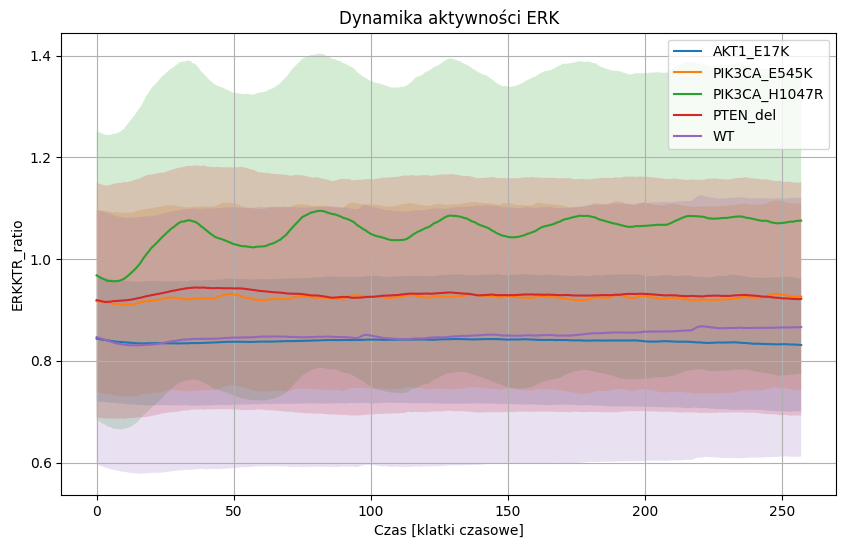

In [11]:
# Wykres ERK
plot_signal(grouped, 'ERK_mean', 'ERK_std', 'Dynamika aktywności ERK', 'ERKKTR_ratio')

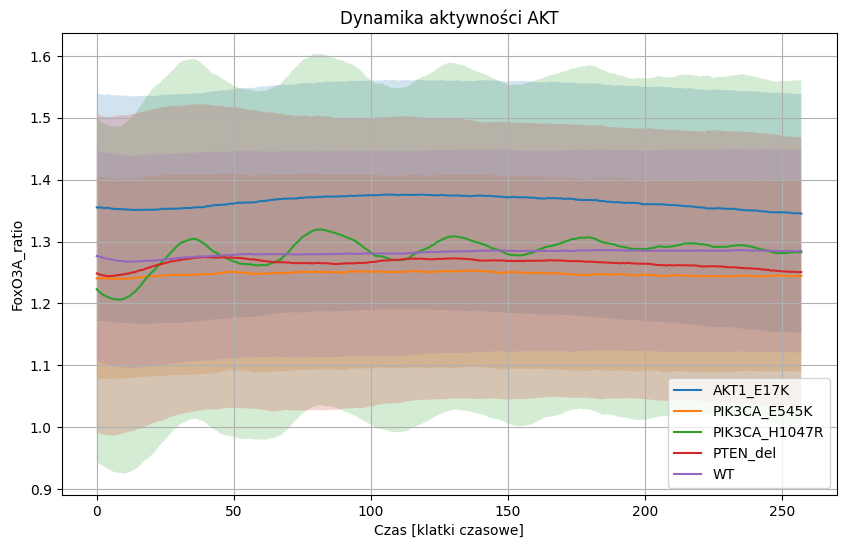

In [12]:
# Wykres AKT
plot_signal(grouped, 'AKT_mean', 'AKT_std', 'Dynamika aktywności AKT', 'FoxO3A_ratio')

### Porównanie poziomów aktywności między WT a każdą z mutacji w przedziale czasowym 60 - 180 min.

In [29]:
# Filtrowanie przedziału czasu, zdjęcia robione co 5 min, więc 12 - 60 min, 36 - 180 min.
time_filtered = df[(df['Image_Metadata_T'] >= 12) & (df['Image_Metadata_T'] <= 36)]
mean_activity = time_filtered.groupby(['Mutation', 'Image_Metadata_T']).agg(
    ERK_mean=('ERKKTR_ratio', 'mean'),
    AKT_mean=('FoxO3A_ratio', 'mean')
).reset_index()
print(mean_activity.head())

    Mutation  Image_Metadata_T  ERK_mean  AKT_mean
0  AKT1_E17K                12  0.835459  1.351532
1  AKT1_E17K                13  0.835176  1.351192
2  AKT1_E17K                14  0.834668  1.351173
3  AKT1_E17K                15  0.834381  1.351108
4  AKT1_E17K                16  0.834292  1.351229


##### Funkcja do przeprowadzenia testu Manna-Whitneya, zwraca listę krotek (nazwa mutacji, statystyka testu, p-value)

In [67]:
def test_vs_wt(df, mean_col):
    results = []
    wt_data = df[df['Mutation'] == 'WT'][mean_col]
    for mut in df['Mutation'].unique():
        if mut == 'WT':
            continue
        mut_data = df[df['Mutation'] == mut][mean_col]
        stat, p = mannwhitneyu(wt_data, mut_data, alternative='two-sided')
        results.append((mut, stat, p))
    return results

##### Funkcja do korygowania p-wartości metodą Bonferroniego. Zwraca dataframe z kolumnami: nazwa mutacji, statystyka testu, p-value, p-value (skorygowana) oraz istotność statystyczną. 

In [68]:
def correct_pvalues(results):
    mutations, stats, pvals = zip(*results) 
    corrected = multipletests(pvals, method='bonferroni')
    corrected_pvals = corrected[1]
    significance = corrected[0]
    return pd.DataFrame({
        'Mutacja': mutations,
        'Statystyka testu': stats, 
        'p-wartość': pvals,
        'p-wartość (skorygowana)': corrected_pvals,
        'Istotne': significance
    })

In [69]:
erk_results = test_vs_wt(mean_activity, 'ERK_mean')
akt_results = test_vs_wt(mean_activity, 'AKT_mean')

In [70]:
erk_df = correct_pvalues(erk_results)
akt_df = correct_pvalues(akt_results)

In [71]:
print("Testy istotności - ERK:")
print(erk_df)

Testy istotności - ERK:
         Mutacja  Statystyka testu     p-wartość  p-wartość (skorygowana)  \
0      AKT1_E17K             319.0  9.073220e-01             1.000000e+00   
1   PIK3CA_E545K               0.0  1.415656e-09             5.662625e-09   
2  PIK3CA_H1047R               0.0  1.415656e-09             5.662625e-09   
3       PTEN_del               0.0  1.415656e-09             5.662625e-09   

   Istotne  
0    False  
1     True  
2     True  
3     True  


In [34]:
print("Testy istotności - AKT:")
print(akt_df)

Testy istotności - AKT:
         Mutacja  Statystyka testu     p-wartość  p-wartość (skorygowana)  \
0      AKT1_E17K               0.0  1.415656e-09             5.662625e-09   
1   PIK3CA_E545K             625.0  1.415656e-09             5.662625e-09   
2  PIK3CA_H1047R             327.0  7.858989e-01             1.000000e+00   
3       PTEN_del             499.0  3.074624e-04             1.229850e-03   

   Istotne  
0     True  
1     True  
2    False  
3     True  


## Zadanie 2 - Analiza koordynacji przestrzennej i dynamiki sygnału.

### Identyfikacja komórek aktywnych za pomocą Z-score.

In [42]:
df['ERK_Zscore'] = df.groupby('track_id')['ERKKTR_ratio'].transform(lambda x: (x - x.mean()) / x.std())

In [43]:
# Obliczenie 90 percentyla i obranie go za threshold.
threshold_90 = np.percentile(df['ERK_Zscore'], 90)
print(f"Próg Z-score dla 90. percentyla: {threshold_90}")
df['ERK_active'] = df['ERK_Zscore'] > threshold_90

Próg Z-score dla 90. percentyla: 1.3404425721305768


### Obliczenie liczby aktywnych sąsiadów dla każdej aktywnej komórki w zadanym promieniu (10)

##### Funkcja identyfikująca aktywne komórki i licząca średnią liczbę aktywnych komórek w jej otoczeniu

In [39]:
def count_active_neighbors(df, time_point, radius=10):
    active_cells = df[(df['Image_Metadata_T'] == time_point) & (df['ERK_active'] == True)]
    positions = active_cells[['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values
    tree = KDTree(positions)

    neighbor_counts = []
    for i, pos in enumerate(positions):
        neighbors = tree.query_ball_point(pos, radius)
        neighbor_counts.append(len(neighbors) - 1)  # Pomijamy siebie
    return np.mean(neighbor_counts)

##### Obliczanie średniej dla każdej mutacji oraz rysowanie wykresu

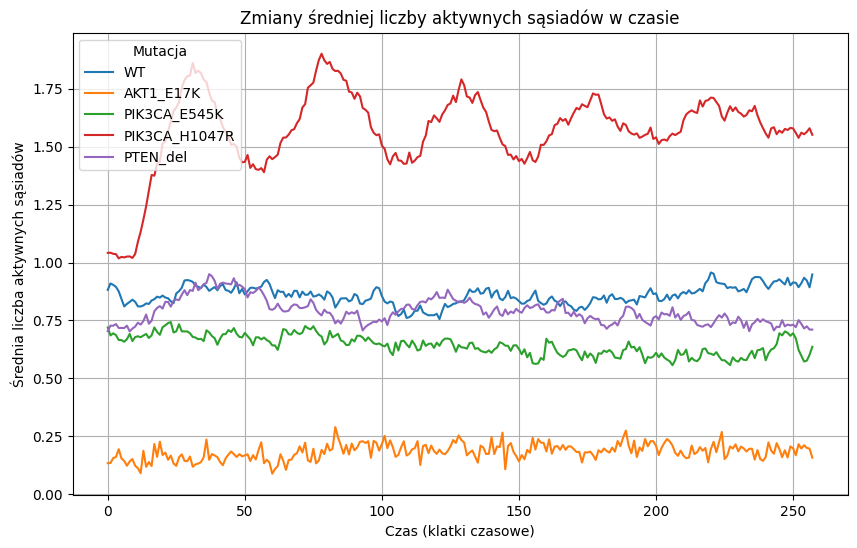

In [41]:
mutations = df['Mutation'].unique()
neighbor_averages = []
for mutation in mutations:
    df_mut = df[df['Mutation'] == mutation]
    time_points = df_mut['Image_Metadata_T'].unique()
    for t in time_points:
        avg_neighbors = count_active_neighbors(df_mut, t, radius=10)
        neighbor_averages.append((t, avg_neighbors, mutation))

neighbor_df = pd.DataFrame(neighbor_averages, columns=['Time', 'Avg_Active_Neighbors', 'Mutation'])

plt.figure(figsize=(10, 6))
sns.lineplot(x='Time', y='Avg_Active_Neighbors', data=neighbor_df, hue='Mutation')
plt.title('Zmiany średniej liczby aktywnych sąsiadów w czasie')
plt.xlabel('Czas (klatki czasowe)')
plt.ylabel('Średnia liczba aktywnych sąsiadów')
plt.legend(title='Mutacja')
plt.grid(True)
plt.show()

### Sprawdzenie autokorelacji przestrzennej za pomocą statystyki I Morana oraz analizę kolejnych klatek czasowych.
##### Dla uproszczenia obliiczeń będziemy liczyć współczynnik I tylko dla eksperymentu pierwszego.

In [44]:
df_exp1 = df[df['Exp_ID'] == 1]
moran_results = []

for mutation in df_exp1['Mutation'].unique():
    df_mut = df_exp1[df_exp1['Mutation'] == mutation]

    for t in df_mut['Image_Metadata_T'].unique():
        df_time = df_mut[df_mut['Image_Metadata_T'] == t]

        positions = df_time[['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values
        activity = df_time['ERK_active'].astype(int).values

        w = DistanceBand(positions, threshold=20, binary=True, silence_warnings=True)
        moran = Moran(activity, w)

        moran_results.append({
            'Mutation': mutation,
            'Time': t,
            'Moran_I': moran.I,
            'p_value': moran.p_sim
        })


moran_df = pd.DataFrame(moran_results)

# Obliczenie średniego Moran’s I dla każdej mutacji
moran_mean = moran_df.groupby('Mutation').agg(
    Moran_I_mean=('Moran_I', 'mean'),
    Moran_I_std=('Moran_I', 'std')
).reset_index()

print(moran_mean)

        Mutation  Moran_I_mean  Moran_I_std
0      AKT1_E17K      0.006120     0.007749
1   PIK3CA_E545K      0.007341     0.009001
2  PIK3CA_H1047R      0.001651     0.018291
3       PTEN_del      0.002838     0.015118
4             WT      0.013674     0.008876


##### Następnie stworzymy mapę aktywności komórek. Będziemy ją tworzyć dla WT oraz eksperymentu 1, ale może być to dostosowane na potrzeby innych analiz.

In [49]:
def plot_activity_map(df, time_point, exp_id, mutation):
    active_cells = df[(df['Image_Metadata_T'] == time_point) & (df['ERK_active'] == True) & (df['Exp_ID'] == exp_id) & (df['Mutation'] == mutation)]
    non_active_cells = df[(df['Image_Metadata_T'] == time_point) & (df['ERK_active'] == False ) & (df['Exp_ID'] == exp_id) & (df['Mutation'] == mutation)]
    plt.figure(figsize=(8, 6))
    plt.scatter(active_cells['objNuclei_Location_Center_X'], active_cells['objNuclei_Location_Center_Y'], c='r', alpha=0.5, zorder=2, label='Komórki aktywne')
    plt.scatter(non_active_cells['objNuclei_Location_Center_X'], non_active_cells['objNuclei_Location_Center_Y'], c='grey',
                alpha=0.2, zorder=1, label='Komórki nieaktywne')
    plt.title(f'Aktywność komórek na płaszczyźnie XY (Czas: {time_point})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()
    plt.show()

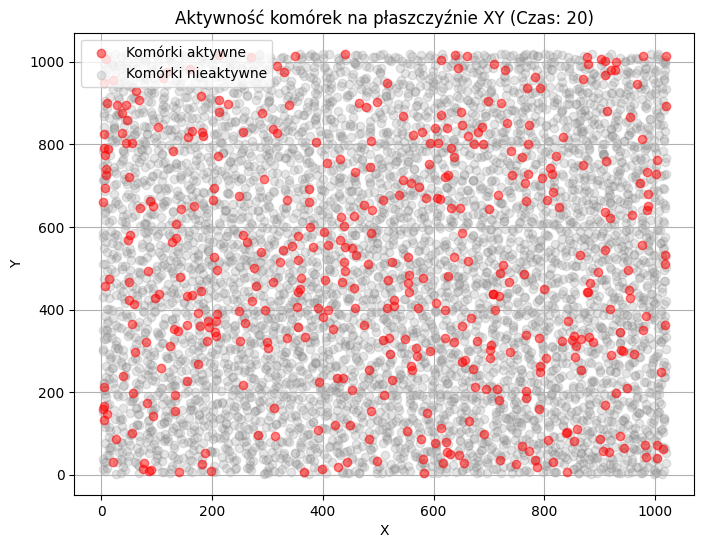

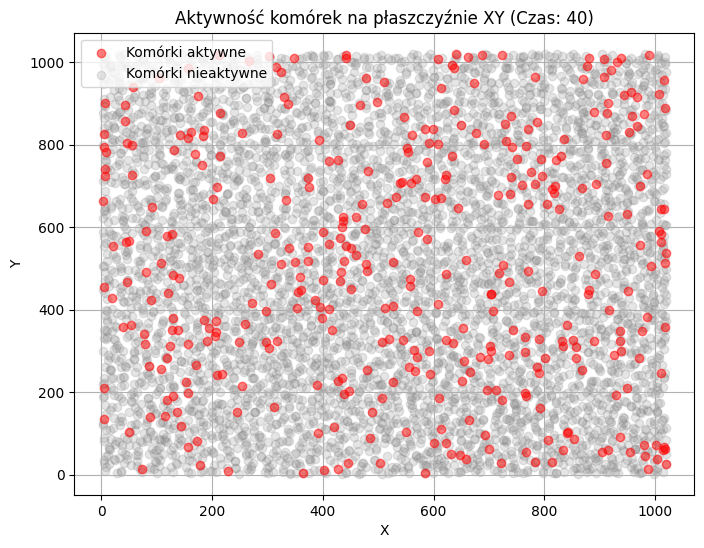

In [50]:
plot_activity_map(df, 20, 1, "WT")
plot_activity_map(df, 40, 1, "WT")

## Zadanie 3 - Porównanie liczby pików aktywności między mutacjami.

##### Funkcja oblicza Z-score dla danej komórki

In [51]:
def compute_zscore(cell_data):
    return (cell_data - cell_data.mean()) / cell_data.std()

##### Dla każdej komórki obliczamy liczbę pików aktywności AKT

In [54]:
df['FoxO3A_Zscore'] = df.groupby('track_id')['FoxO3A_ratio'].transform(compute_zscore)
threshold_90 = np.percentile(df['FoxO3A_Zscore'], 90)
df['AKT_peak'] = df['FoxO3A_Zscore'] > threshold_90

In [79]:
peak_counts = df.groupby(['track_id', 'Mutation'])['AKT_peak'].sum().reset_index()
peak_counts.rename(columns={'AKT_peak': 'peak_count'}, inplace=True)
print(peak_counts.head())

   track_id       Mutation  peak_count
0         1      AKT1_E17K         687
1         1   PIK3CA_E545K         253
2         1  PIK3CA_H1047R        1330
3         1       PTEN_del         682
4         1             WT         110


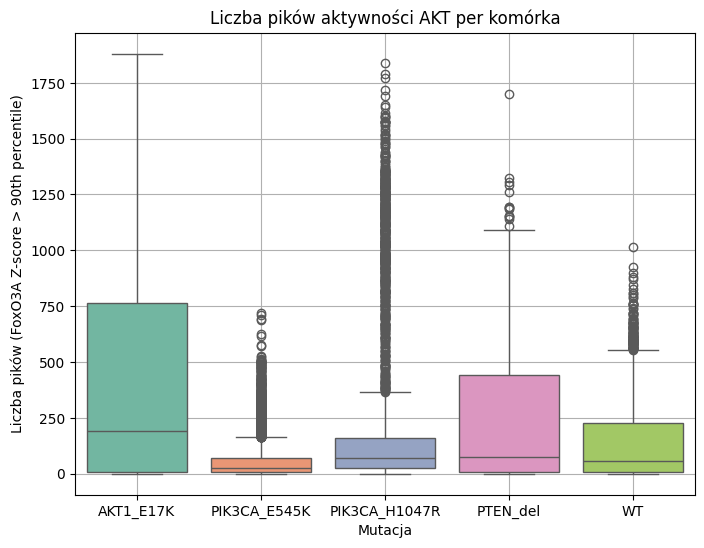

In [62]:
plt.figure(figsize=(8,6))
sns.boxplot(data=peak_counts, x='Mutation', y='peak_count', hue='Mutation', palette='Set2', legend=False)
plt.title('Liczba pików aktywności AKT per komórka')
plt.ylabel('Liczba pików (FoxO3A Z-score > 90th percentile)')
plt.xlabel('Mutacja')
plt.grid(True)
plt.show()